# Stock Portfolio Building And Evaluation with Monte Carlo Simulation

In the following notebook:
1. Stock prices of IBM, GE and Disney Corporation are visualized
2. An optimized portfolio is built using Modern Portfolio Theory (MPT)
3. Monte Carlo Simulation is performed to evaluate the value-at-risk (VaR) for the optimized portfolio
4. VaR is calculated for a given budget at 99% confidence interval

In [174]:
import numpy as np
import quandl
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt as opt
from cvxopt import solvers
import random
 
%matplotlib inline

In [175]:
quandl.ApiConfig.api_key = "BSF1jBjuDiyMSE-6Y1io"
data_ibm = quandl.get("WIKI/IBM", start_date="2000-1-1") #IBM stock data
data_ge = quandl.get("WIKI/GE", start_date="2000-1-1") #General Electrics stock data
data_dis = quandl.get("WIKI/DIS", start_date="2000-1-1") #Disney stock data

In [176]:
stocks = pd.DataFrame({"IBM": data_ibm["Open"],
                      "GE": data_ge["Open"],
                      "DIS": data_dis["Open"]})
 
stocks.head()

,DIS,GE,IBM
Date,,,
2000-01-03,29.13,153.00,112.44
2000-01-04,30.06,147.25,114.00
2000-01-05,32.13,143.75,112.94
2000-01-06,33.00,143.13,118.00
2000-01-07,32.00,148.00,117.25


# Visualization

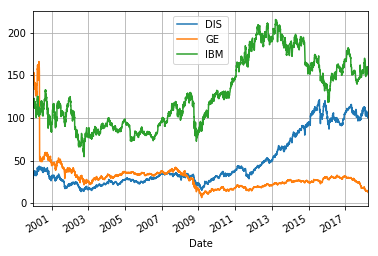

In [160]:
stocks.plot(grid = True)

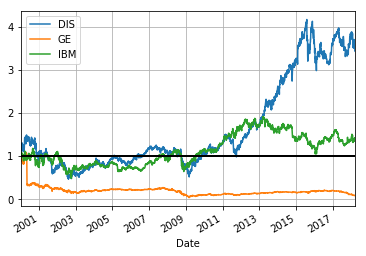

In [161]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return = stock_return.fillna(method='ffill').dropna()
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

One can easily spot the crisis of 2008, when all the stock prices go down.
The general trend is upward.
There is some negative correlation between IBM and Disney, which is a good indicator for the further portfolio building

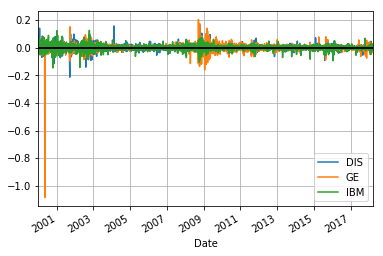

In [162]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

WIth the exception of the dot.com cris period of 2000s and the mortgage crisis of 2008-2009, all stocks seem to have low volatility-that is, risk.

# Building a Portfolio

Modern portfolio theory (MPT), or mean-variance analysis, introduced by Harry Markowitz, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk, defined as variance. Its key insight is that an asset’s risk and return should not be assessed by itself, but by how it contributes to a portfolio’s overall risk and return.

In [163]:
np.random.seed(1)
n_obs = 1000
n_assets = 3
artificial_returns = np.random.randn(n_obs, n_assets) + 0.05
artificial_returns

array([[ 1.67434536, -0.56175641, -0.47817175],
       [-1.02296862,  0.91540763, -2.2515387 ],
       [ 1.79481176, -0.7112069 ,  0.3690391 ],
       ..., 
       [ 1.22745439,  0.21508508,  0.28311264],
       [-1.75272205, -0.72189048, -0.57265658],
       [-0.10065961, -1.35002289, -1.25106608]])

In [164]:
def create_random_weights(n_assets):
    w = np.random.rand(n_assets)
    return w / w.sum()
 
def evaluate_random_portfolio(returns):
    
    returns = pd.DataFrame(returns)   
    
    cov = np.matrix(returns.cov())
    R = np.matrix(returns.mean())
    w = np.matrix(create_random_weights(returns.shape[1]))
    
    mu = w * R.T
    sigma = np.sqrt(w * cov * w.T)
    
    return mu, sigma
 
def create_random_portfolios(returns, n_portfolios=1500):
   
    pf_mus, pf_sigmas = np.column_stack([evaluate_random_portfolio(returns) for _ in range(n_portfolios)])
 
    return pf_mus, pf_sigmas

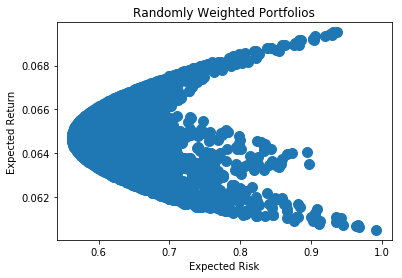

In [165]:
pf_mus, pf_sigmas = create_random_portfolios(artificial_returns, n_portfolios=3000)
 
plt.plot(pf_sigmas, pf_mus, 'o', markersize=10)
plt.xlabel('Expected Risk')
plt.ylabel('Expected Return')
plt.title('Randomly Weighted Portfolios')
plt.show()

In [166]:
def calculate_frontier(returns):
   
    returns = stock_return
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    
    optimal_mus = []
    r_min = pbar.mean() 
    for i in range(50):
        optimal_mus.append(r_min)
        r_min += (pbar.mean() / 100)
    
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    opt.solvers.options['show_progress'] = False
    
    optimal_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in optimal_mus]
    
    optimal_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in optimal_weights]
    
    return optimal_weights, optimal_mus, optimal_sigmas

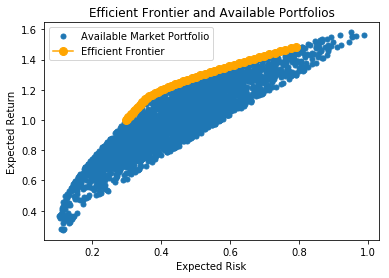

In [167]:
pf_mus, pf_sigmas = create_random_portfolios(stock_return, n_portfolios=3000)
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(stock_return)
 
plt.plot(pf_sigmas, pf_mus, 'o', markersize=5, label='Available Market Portfolio')
plt.plot(optimal_sigmas, optimal_mus, 'y-o', color='orange', markersize=8, label='Efficient Frontier')
plt.xlabel('Expected Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Available Portfolios')
plt.legend(loc='best')
plt.show()

In [168]:
weights = random.choice(optimal_weights) 
portfolio = pd.DataFrame({"Prices": data_ibm["Open"] * weights[0] + data_ge["Open"] * weights[1] + data_dis["Open"] * weights[2],
                      "Returns": stock_return.iloc[:,0] * weights[0] + stock_return.iloc[:,1] * weights[1] + stock_return.iloc[:,0] * weights[2]
                       })
 
portfolio.head()


,Prices,Returns
Date,,
2000-01-03,82.495480,1.000000
2000-01-04,83.829036,1.031926
2000-01-05,83.894067,1.102987
2000-01-06,87.448034,1.132853
2000-01-07,86.608176,1.098524


Random weights are chosen from the weights that comprise the efficient frontier. Then a portfolio is build using these weights and a dataframe is created with the prices and returns

# Monte Carlo Simulation for Value at Risk

In [169]:
budget = 10000
starting_price = portfolio.iloc[-1,0]
periods = 365
mean = portfolio["Returns"].mean()
std = portfolio["Returns"].std()

In [170]:
def stock_simulator(starting_price,periods,mean,std):
    X_axis = []
    Y_axis = []
    
    current_period = 1
    previous_price = starting_price
    
    while current_period <= periods:
        
        drift = float(mean)/periods
        shock = np.random.normal(loc=drift,scale=float(std)/np.sqrt(periods))
        
        current_price = previous_price + previous_price*(drift + shock)
        previous_price = current_price
        
        X_axis.append(current_period)
        Y_axis.append(current_price)
        
        current_period = current_period + 1
    
    plt.subplot(121)
    plt.plot(X_axis,Y_axis)
    return Y_axis[-1]

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


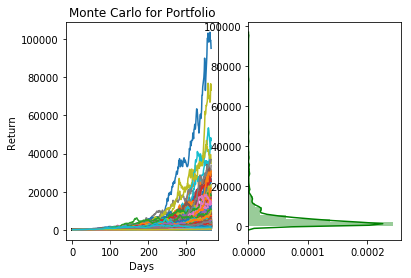

In [171]:
simulations=0
outcomes = []
while simulations < 1000:
    outcomes.append(stock_simulator(starting_price,periods,mean,std))
    simulations += 1
    
plt.ylabel('Return')
plt.xlabel('Days')
plt.title("Monte Carlo for Portfolio")
plt.subplot(122)
sns.distplot(outcomes,bins=50,color="green",vertical=True)

We can see right skewed distributions of Monte Carlo simulation for the stocks. This is a positive indicator. It means that on average, the portfolio does not have losses. Perhaps this occurs because of the optimization of the portfolio prior to the performance of the simulation

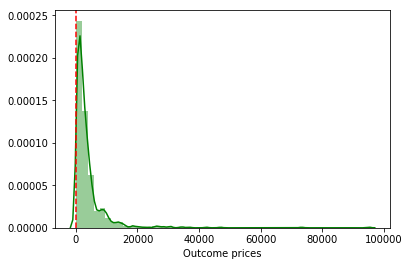

In [172]:
q = np.percentile(outcomes,1) 
sns.distplot(outcomes,color="green",vertical=False,axlabel='Outcome prices')
plt.axvline(q, color="red", linestyle="--") 

In [173]:
VaR_coef = (starting_price - q)/starting_price
VaR = VaR_coef*budget
print(VaR)

-4335.11028721


Although VaR is usually postitive, since it is a measure of possible loss, in our case a negative VaR is observed, which means that at 99% confidence interval, the portfolio has no value at risk. It has high returns. Perhaps this occurs because the portfolio has been optimized in the beginning and because the stocks that comprise the portfolio havelow volatility